<a href="https://colab.research.google.com/github/tis-abe-akira/langchain-academy/blob/main/module-3/time-travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time travel

## 復習

「人間がループの中に入る」ための動機について説明しました。

(1) `承認` - エージェントを中断し、ユーザーに状態を提示して、ユーザーがアクションを承認できるようにします。

(2) `デバッグ` - グラフを巻き戻して、問題を再現または回避できます。

(3) `編集` - 状態を変更できます。

ブレークポイントは、特定のノードでグラフを停止したり、グラフが動的に中断できるようにしたりする方法を示しました。

次に、人間の承認で続行したり、人間のフィードバックでグラフの状態を直接編集する方法を示しました。

## 目標

それでは、LangGraphが、過去の状態を表示、再生、さらにはフォークすることで、[デバッグをサポート](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/)する方法を示します。

我々はこれを `time travel`と呼びます。

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


Agentを構築しましょう。

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

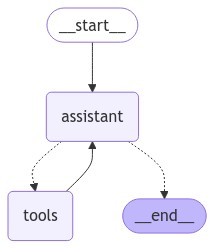

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

以前と同様に実行します。

In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_floShW6z59AP3hQBlSdGahif)
 Call ID: call_floShW6z59AP3hQBlSdGahif
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

`thread_id`を指定して、`get_state`を使用してグラフの**現在の**状態を確認できます！

In [6]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_floShW6z59AP3hQBlSdGahif', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-30652f4e-4288-4680-8bda-6502cfd8c14b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_floShW6z59AP3hQBlSdGahif', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

エージェントの状態履歴も閲覧できます。

`get_state_history` を使用すると、過去のすべてのステップにおける状態を取得できます。


In [7]:
all_states = [s for s in graph.get_state_history(thread)]

In [8]:
len(all_states)

5

最初の要素は、`get_state` から取得したものと同じように、現在の状態です。

In [12]:
# 後ろから2番目の状態を見る
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa0777-e10a-693b-8000-13da13b07d86'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-11-11T21:54:14.834789+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa0777-e102-6211-bfff-9c8f3d16fd96'}}, tasks=(PregelTask(id='b714a9b2-c4b1-4a52-de03-05d002087fc0', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_floShW6z59AP3hQBlSdGahif', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

上記すべてをここで視覚化できます。

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying

過去のいずれかのステップからエージェントを再実行できます。

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

人間の入力を受け取ったステップに戻ってみましょう！

In [13]:
to_replay = all_states[-2]

In [17]:
# 結果が見づらいので次のステップで、values, nextを個別に表示している。
to_replay


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa0777-e10a-693b-8000-13da13b07d86'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-11-11T21:54:14.834789+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa0777-e102-6211-bfff-9c8f3d16fd96'}}, tasks=(PregelTask(id='b714a9b2-c4b1-4a52-de03-05d002087fc0', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_floShW6z59AP3hQBlSdGahif', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

ステートを見てみましょう。

In [15]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c')]}

呼び出す次のノードを確認できます。

In [16]:
to_replay.next

('assistant',)

また、`checkpoint_id` と `thread_id` を示す構成情報も取得できます。

In [18]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa0777-e10a-693b-8000-13da13b07d86'}}

ここから再生するには、構成情報(config)をエージェントに渡すだけです！

グラフは、このチェックポイントがすでに実行されていることを認識しています。

このチェックポイントから再生するだけです！

In [19]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_OzlZcZ9HRh4UsSHvaeechn8f)
 Call ID: call_OzlZcZ9HRh4UsSHvaeechn8f
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, we can see our current state after the agent re-ran.

## Forking

同じステップから、**異なる入力で実行したい場合**はどうでしょうか。

これが分岐です。

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [20]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c')]

Again, we have the config.

In [21]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa0777-e10a-693b-8000-13da13b07d86'}}

## チェックポイントの状態を変更

このチェックポイントの状態を変更してみましょう。

`checkpoint_id` を指定して `update_state` を実行するだけです。

`messages` のリデューサーがどのように動作するかを思い出してください。

* メッセージ ID を指定しない限り、追加されます。
* 状態に追加するのではなく、メッセージを上書きするためにメッセージ ID を指定します！

したがって、メッセージを上書きするには、`to_fork.values["messages"].id` にあるメッセージ ID を指定するだけです。

In [22]:
# fork_config = graph.update_state(
#     to_fork.config,
#     {"messages": [HumanMessage(content='Multiply 5 and 3',
#                                id=to_fork.values["messages"][0].id)]},
# )
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='5 掛ける 3 を計算してください。',
                               id=to_fork.values["messages"][0].id)]},
)

In [23]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa079a-5592-6665-8001-b9c38d015da6'}}

これにより、新しい分岐チェックポイントが作成されます。

ただし、次の移動先などのメタデータは保持されます！

エージェントの現在の状態がフォークで更新されていることがわかります。

In [24]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='5 掛ける 3 を計算してください。', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c')]

In [25]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='5 掛ける 3 を計算してください。', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa079a-5592-6665-8001-b9c38d015da6'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='5 掛ける 3 を計算してください。', additional_kwargs={}, response_metadata={}, id='5f43e3e3-8945-4cf2-adeb-b7dacfec315c')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efa0777-e10a-693b-8000-13da13b07d86'}, created_at='2024-11-11T22:09:39.734437+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa0777-e10a-693b-8000-13da13b07d86'}}, tasks=(PregelTask(id='10388311-a6a5-2a65-3683-d162ab768b88', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

これで、ストリーミングすると、グラフはこのチェックポイントが実行されたことがないことを認識します。

したがって、グラフは単純に再生するのではなく、実行されます。

In [26]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

5 掛ける 3 を計算してください。
================================== Ai Message ==================================
Tool Calls:
  multiply (call_9up5qCM6b626igLA7HHTRqRH)
 Call ID: call_9up5qCM6b626igLA7HHTRqRH
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

5 掛ける 3 は 15 です。


これで、現在の状態がエージェント実行の最後であることがわかります。

In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', id='4ee8c440-0e4a-47d7-852f-06e2a6c4f84d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KP2CVNMMUKMJAQuFmamHB21r', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bc420009-d1f6-49b8-bea7-dfc9fca7eb79-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_KP2CVNMMUKMJAQuFmamHB21r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 148}), ToolMessage(content='15', name='multiply', id='9232e653-816d-471a-9002-9a1ecd453364', tool_call_id='call_KP2CVNMMUKMJAQuFmamHB21r'), AIMessage(content='The result of multiplying 5 and 3 is 15.', additi

### Time travel with LangGraph API

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

*Also, if you are running this notebook in CoLab, then skip this step.*

--

Let's load our `agent` in the Studio UI, which uses `module-3/studio/agent.py` set in `module-3/studio/langgraph.json`.

![Screenshot 2024-08-26 at 9.59.19 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570bec_time-travel4.png)

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation).

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:62780")

#### Re-playing

Let's run our agent streaming `updates` to the state of the graph after each node is called.

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-2c120fc3-3c82-4599-b8ec-24fbee207cad', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '3b40d091-58b2-4566-a84c-60af67206307', 'tool_call_id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

Now, let's look at **replaying** from a specified checkpoint.

We simply need to pass the `checkpoint_id`.

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {'example': False,
     'additional_kwargs': {},
     'response_metadata': {}},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e497456f-827a-5027-87bd-b0ccd54aa89a',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a449-7fbc-6c90-8754-4e6b1b582790',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '708e1d8f-f7c8-4093-9bb4-999c4237cb4a',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:33:51.380352+00:00',
 'checkpoint_id': '1ef6a449-817f-6b55-8000-07c18fbdf7c8',
 'parent_checkpoint_id': '1ef6a449-816c-6fd6-bfff-32a56dd2635f'}

Let's stream with `stream_mode="values"` to see the full state at every node as we replay.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a44a-5806-6bb1-b2ee-92ecfda7f67d'}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_Rn9YQ6iZyYtzrELBz7EfQcs0', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_1

We can all view this as streaming only `updates` to state made by the nodes that we reply.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-550e75ad-dbbc-4e55-9f00-aa896228914c', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '731b7d4f-780d-4a8b-aec9-0d8b9c58c40a', 'tool_call_id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

#### Forking

Now, let's look at forking.

Let's get the same step as we worked with above, the human input.

Let's create a new thread with out agent.

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-cbd081b1-8cef-4ca8-9dd5-aceb134404dc', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '11dd4a7f-0b6b-44da-b9a4-65f1677c8813', 'tool_call_id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
   'example': False}]}

In [ ]:
to_fork['values']['messages'][0]['id']

'93c18b95-9050-4a52-99b8-9374e98ee5db'

In [ ]:
to_fork['next']

['assistant']

In [ ]:
to_fork['checkpoint_id']

'1ef6a44b-27ec-681c-8000-ff7e345aee7e'

Let's edit the state.

Remember how our reducer on `messages` works:

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [ ]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [ ]:
forked_config

{'configurable': {'thread_id': 'c99502e7-b0d7-473e-8295-1ad60e2b7ed2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'},
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'}

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'da5d6548-62ca-5e69-ba70-f6179b2743bd',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 1,
  'source': 'update',
  'writes': {'__start__': {'messages': {'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
     'name': None,
     'type': 'human',
     'content': 'Multiply 3 and 3',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}}},
  'parents': {},
  'graph_id': 'agent'},
 'created_at': '2024-09-03T22:34:46.678333+00:00',
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34',
 'parent_checkpoint_id': '1ef6a44b-27ec-681c-8000-ff7e345aee7e'}

To rerun, we pass in the `checkpoint_id`.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-e9759422-e537-4b9b-b583-36c688e13b4b', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '89787b0b-93de-4c0a-bea8-d2c3845534e1', 'tool_call_id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.